# Taller dos- Procesamiento de lenguaje natural

Se entregan dos potenciales bases de datos:
1. más de 1.000 tweets relacionados con el tema energético nacional, divididos en 2 archivos, clasificados por empleados de una empresa energética como positivos y negativos. Los tweets están cortados.
2. 800 tweets de propósito general (archivo tweets_800.xlsx) clasificados en positivo (1), negativo (-1) y neutro (0)

Su tarea es:
- Utilizando Transformers, calificar su sentimiento y encontrar métricas de precisión, recall y F1 score.
- Obtener entidades nombradas (NER) y realizar un wordcloud de las mismas.
- Apoyado en word embeddings, realizar un gráfico t-sne para los conceptos claves del tema (explicar grupos potenciales que se observan en el gráfico).


# 1. Librerias 

In [62]:
# Carga de información 
import pandas as pd 

# Limpieza Tweets
import re

# Metodología transformers 
from transformers import pipeline

# Metricas de validación
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Para plot
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
# para calculos
import numpy as np

#ignorar warnings 
import warnings
warnings.filterwarnings("ignore")

# for WordEmbeding 
import nltk
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

#MODELO TSNE
from sklearn import manifold


import re
import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

import spacy


import seaborn as sns 

import transformers
from transformers import pipeline

from copy import deepcopy

# 2. Carga del Dataset

In [63]:
df = pd.read_excel('tweets_800.xlsx')

In [64]:
df.info()
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   TWEET ORIGINAL  800 non-null    object
 1   POLARIDAD       800 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.6+ KB


TWEET ORIGINAL  POLARIDAD
795  Estos panes integrales de #ProsanaFoods están ...          1
796  #DisparaManiguisDispara @faustoponce @Horacitu...          1
797             Listo. A empezar con las metas del año          1
798  Mi palabra preferida para este 2016, fue grati...          1
799  @Alphasniper97 Alpha suerte y ten un feliz año...          1

# 3. Limpieza de los tweets 

In [65]:
def CleanTweets(text):
    text = re.sub(r'@_[A-Za-z0-9]+_','',text) #Remover @_menciones_
    text = re.sub(r'@[A-Za-z0-9]+_[A-Za-z0-9]+','',text) #Remover @menciones_
    text = re.sub(r'@[A-Za-z0-9]+','',text) #Remover @menciones
    text = re.sub(r'https?:\/\/\S+','',text) #Remover Hypervinculos
    text = re.sub(r'RT[\s]+','',text) #Remover Retweets
    text = re.sub(r'#[A-Za-z0-9]+','',text) #Remover "#"
    text = re.sub(r'[0-9]','',text) #remover numeros
    text = re.sub(r'[^\w\s]',' ',text) #remover signos de puntuacion
    text = re.sub(r'\n|\t',' ',text) #remover saltos de linea
    text = re.sub(r'[\s]+',' ',text) #reemplazar espacios dobles por espacion sencillos
    text = re.sub(r"^[\s]",'',text) #eliminar espacios al inicio de cada tweet
    #text=text.lower() #todo a minuscula
    return text

df.columns = ['tweet_original', 'polaridad']
df = df.assign(tweetLimpio= df.tweet_original.apply(CleanTweets))
df.head(5)

tweet_original  polaridad  \
0  @robertobrenes Bueno, no es tanto lo mayor com...         -1   
1  Acabo de ver una chamaca con un piercing de mo...         -1   
2  "Mae mañana llego a las 10, cuidado te quedas ...         -1   
3  @rociomoram29 que mal y por eso es que están j...         -1   
4  @KristelS18 Acá tengo pero ugh, la canela no m...         -1   

                                         tweetLimpio  
0  Bueno no es tanto lo mayor como cuánto de camp...  
1  Acabo de ver una chamaca con un piercing de mo...  
2  Mae mañana llego a las cuidado te quedas dormi...  
3  que mal y por eso es que están jugando yo creo...  
4  Acá tengo pero ugh la canela no me gusta mucho...

# 4. Utilizando Transformers, calificar su sentimiento y encontrar métricas de precisión, recall y F1 score.

Para el desarrollo de esta metodologia a través de la librería *Transformers*, usaremos la tarea de *ext-classification (Sentiment-Analysis)* y partir de ella implementaremos diferentes modelos, los cuales son:
- **Modelo defecto de la libreria**
- **finiteautomata/beto-sentiment-analysis**  [modelos automatas finitos](https://huggingface.co/finiteautomata)  Modelo entrenado con el corpus TASS 2020 (alrededor de ~5k tweets) de varios dialectos del español. El modelo base es BETO, un modelo BERT entrenado en español.
- **nlptown/bert-base-multilingual-uncased-sentiment** [url info ](https://huggingface.co/nlptown/bert-base-multilingual-uncased-sentiment) Se trata de un modelo multilingüe basado en Bert que se ha ajustado para el análisis del sentimiento de las reseñas de productos en seis idiomas: inglés, holandés, alemán, francés, español e italiano. Predice el sentimiento de la reseña como un número de estrellas (entre 1 y 5). Este modelo está pensado para su uso directo como modelo de análisis de sentimientos para las reseñas de productos en cualquiera de los seis idiomas mencionados, o para su posterior ajuste en tareas de análisis de sentimientos relacionadas. Se trata de un modelo multilingüe basado en Bert que se ha ajustado para el análisis del sentimiento de las reseñas de productos en seis idiomas: inglés, holandés, alemán, francés, español e italiano. Predice el sentimiento de la reseña como un número de estrellas (entre 1 y 5). Este modelo está pensado para su uso directo como modelo de análisis de sentimientos para las reseñas de productos en cualquiera de los seis idiomas mencionados, o para su posterior ajuste en tareas de análisis de sentimientos relacionadas.
- **tr3cks/3LabelsSentimentAnalysisSpanishtr3cks/3LabelsSentimentAnalysisSpanish** [link modelo](https://huggingface.co/tr3cks/3LabelsSentimentAnalysisSpanishhttps://huggingface.co/tr3cks/3LabelsSentimentAnalysisSpanish)

### a. Modelo General

In [66]:
def evaluate_model(task_, model_, categories_model, polarity = df.polaridad):
    """
    Dado indicaciones del modelo retorna matriz de confusion y  reporte de clasificacion 
    """
    global df
    classifier = pipeline(task = task_, model = model_)
    listTweets = list(df.tweetLimpio)
    classification = classifier(listTweets)
    labelClass = list()
    scoreClass = list()
    for i in range(len(listTweets)):
        labelClass.append(classification[i]['label'])
        scoreClass.append(classification[i]['score'])
    print(set(labelClass))  
    for category_, number_ in categories_model.items():
        labelClass = list(map(lambda x: x.replace(category_, number_), labelClass))
    labelClass = [int(i) for i in labelClass]
    cm = confusion_matrix(polarity, labelClass)
    rc = classification_report(polarity, labelClass)
    
    return cm, rc 

##### Evaluación Modelos

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


{'NEGATIVE', 'POSITIVE'}
None
----------------------------------------------------------------------------------------------------
[[269   0  42]
 [220   0  39]
 [159   0  71]]
              precision    recall  f1-score   support

          -1       0.42      0.86      0.56       311
           0       0.00      0.00      0.00       259
           1       0.47      0.31      0.37       230

    accuracy                           0.42       800
   macro avg       0.29      0.39      0.31       800
weighted avg       0.30      0.42      0.32       800



Text(0.5, 1.0, 'Matriz de confusión Modelo General')

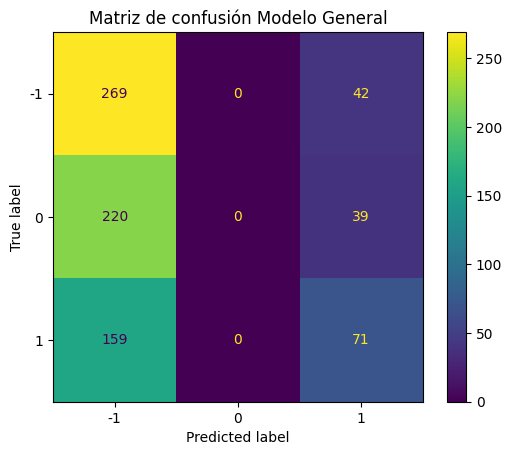

In [67]:
task_ = 'sentiment-analysis'
model_ = None
categories_model = {'NEGATIVE' : '-1',
                   'POSITIVE' :'1'}
polarity = df.polaridad
cm1, rc1 = evaluate_model(task_, model_, categories_model, polarity = df.polaridad)
print(model_)
print('-'*100)
print(cm1)
print(rc1)
cmd = ConfusionMatrixDisplay(cm1,  display_labels=df.polaridad.unique())
cmd.plot()
cmd.ax_.set_title( 'Matriz de confusión Modelo General')

{'POS', 'NEG', 'NEU'}
finiteautomata/beto-sentiment-analysis
----------------------------------------------------------------------------------------------------
[[299   7   5]
 [ 16 235   8]
 [  3  17 210]]
              precision    recall  f1-score   support

          -1       0.94      0.96      0.95       311
           0       0.91      0.91      0.91       259
           1       0.94      0.91      0.93       230

    accuracy                           0.93       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.93      0.93      0.93       800



Text(0.5, 1.0, 'Matriz de confusión Modelo Beto')

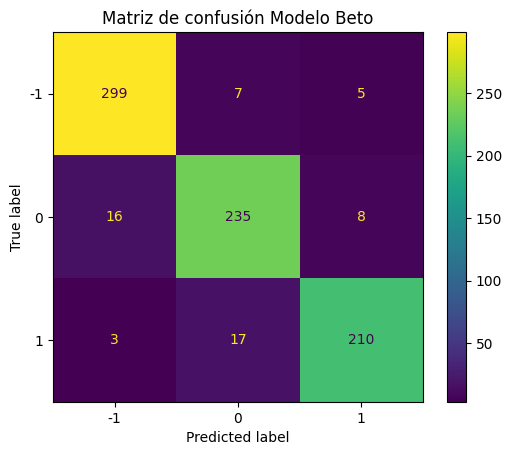

In [68]:
task_ = 'sentiment-analysis'
model_ = 'finiteautomata/beto-sentiment-analysis'
categories_model = {'NEU' : '0',
                   'POS' :'1',
                   'NEG': '-1'}
polarity = df.polaridad
cm1, rc1 = evaluate_model(task_, model_, categories_model, polarity = df.polaridad)
print(model_)
print('-'*100)
print(cm1)
print(rc1)
cmd = ConfusionMatrixDisplay(cm1,  display_labels=df.polaridad.unique())
cmd.plot()
cmd.ax_.set_title( 'Matriz de confusión Modelo Beto')

{'1 star', '4 stars', '2 stars', '3 stars', '5 stars'}
nlptown/bert-base-multilingual-uncased-sentiment
----------------------------------------------------------------------------------------------------
[[227  25  59]
 [133  64  62]
 [ 49  41 140]]
              precision    recall  f1-score   support

          -1       0.56      0.73      0.63       311
           0       0.49      0.25      0.33       259
           1       0.54      0.61      0.57       230

    accuracy                           0.54       800
   macro avg       0.53      0.53      0.51       800
weighted avg       0.53      0.54      0.52       800



Text(0.5, 1.0, 'Matriz de confusión Modelo Bert')

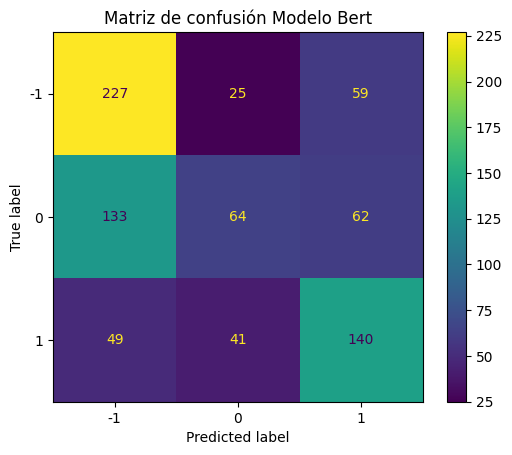

In [69]:
task_ = 'sentiment-analysis'
model_ = 'nlptown/bert-base-multilingual-uncased-sentiment'
categories_model = {'1 star' : '-1',
                    '2 stars' : '-1',
                    '3 stars' : '0',
                    '4 stars' : '1',
                    '5 stars' : '1'}
polarity = df.polaridad
cm1, rc1 = evaluate_model(task_, model_, categories_model, polarity = df.polaridad)
print(model_)
print('-'*100)
print(cm1)
print(rc1)
cmd = ConfusionMatrixDisplay(cm1,  display_labels=df.polaridad.unique())
cmd.plot()
cmd.ax_.set_title( 'Matriz de confusión Modelo Bert')

{'LABEL_0', 'LABEL_1', 'LABEL_2'}
tr3cks/3LabelsSentimentAnalysisSpanish
----------------------------------------------------------------------------------------------------
[[ 32 161 118]
 [ 79  52 128]
 [176  15  39]]
              precision    recall  f1-score   support

          -1       0.11      0.10      0.11       311
           0       0.23      0.20      0.21       259
           1       0.14      0.17      0.15       230

    accuracy                           0.15       800
   macro avg       0.16      0.16      0.16       800
weighted avg       0.16      0.15      0.15       800



Text(0.5, 1.0, 'Matriz de confusión Modelo tr3cks')

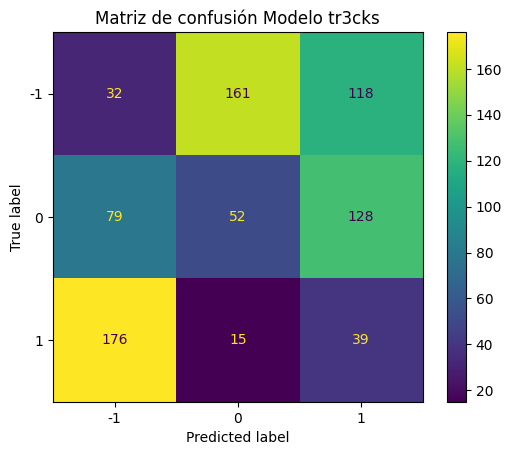

In [70]:
task_ = 'sentiment-analysis'
model_ = 'tr3cks/3LabelsSentimentAnalysisSpanish'
categories_model = {'LABEL_0' : '0',
                   'LABEL_1' :'1',
                   'LABEL_2': '-1'}
polarity = df.polaridad
cm1, rc1 = evaluate_model(task_, model_, categories_model, polarity = df.polaridad)
print(model_)
print('-'*100)
print(cm1)
print(rc1)
cmd = ConfusionMatrixDisplay(cm1,  display_labels=df.polaridad.unique())
cmd.plot()
cmd.ax_.set_title( 'Matriz de confusión Modelo tr3cks')

In [71]:
#task_ = 'sentiment-analysis'
#model_ = 'bigscience/bloom'
#categories_model = {'NEU' : '0',
#                   'POS' :'1',
#                   'NEG': '-1'}
#polarity = df.polaridad
#cm1, rc1 = evaluate_model(task_, model_, categories_model, polarity = df.polaridad)
#print(model_)
#print('-'*100)
#print(cm1)
#print(rc1)
#sns.heatmap(cm1/np.sum(cm1), annot=True, 
#            fmt='.2%', cmap='Blues')

#### Conclusiones

Despues de analizar los diferentes modelos para análisis de sentimientos, llegamos a la conclusión que el modelo **BETO** presenta una mejor clasificación de sentimientos, con respecto a los generales. Tenemos la precisión más alta, con un 94% y la prescede el modelo Bert con un 54%. 

Resaltamos que usar modelos genericos, no son aptos para casos con aceptaciones con terminos medios, ya que no son etiquetas apropiadas para el proceso. 

El modelo tr3cks presenta el pero proceso para clasificación, esto se puede deber a que la clasificación realizada no es apropiada para sentimientos.



# 5. Obtener entidades nombradas (NER) y realizar un wordcloud de las mismas.

In [72]:
def getNerModel(task_, model_):
    """Funcion que arma el dataframe con los resultados del modelo"""
    ner = pipeline(task = task_, model=model_)
    listTweets = list(df.tweetLimpio)
    
    #create list table for nerd
    textNerList = list()
    wordNerList = list()
    entityNerdList = list()
    for i in range(len(listTweets)):
        nerText = ner(listTweets[i])
        if len(nerText)>0:
            for dic_ in nerText:
                textNerList.append(listTweets[i])
                wordNerList.append(dic_['word'])
                entityNerdList.append(dic_['entity'])
                
    dfResultNer = pd.DataFrame({'text': textNerList,
                                 'word' : wordNerList,
                                 'entity': entityNerdList})
    return dfResultNer

In [73]:
def get_dict_for_wordcloud(label_, dfResultNer):
    """Funcion que forma dataframe para wordcloud"""
    #label_ = 'B-PER'#'B-LOC'
    d_temp = dfResultNer.loc[dfResultNer.entity == label_]
    
    #armando diccionario
    d_temp = d_temp.value_counts('word').to_frame()
    d_temp.columns  = ['frecuencia']
    d_temp.index.name="token_index" 
    d_temp = d_temp.assign(token = d_temp.index)

    dictio={}
    for freq,token in d_temp.values:
        dictio[token]=freq
    
    return dictio


Para el desarrollo de las Word cloud, usaremos los siguientes modelos: 

- Davlan/bert-base-multilingual-cased-ner-hrl
 - mrm8488/TinyBERT-spanish-uncased-finetuned-ner  Estos modelos presentan labels del siguiente tipo.


    - O	Outside of a named entity
    - B-PER	Beginning of a person’s name right after another person’s name
    - I-PER	Person’s name
    - B-ORG	Beginning of an organisation right after another organisation
    - I-ORG	Organisation
    - B-LOC	Beginning of a location right after another location
    - I-LOC	Location
    
- CenIA/distillbert-base-spanish-uncased-finetuned-ner  Sus labels no presentan documentación 

### Davlan/bert-base-multilingual-cased-ner-hrl

In [74]:
%%time
task_ = None#'ner'
model_ = 'Davlan/bert-base-multilingual-cased-ner-hrl'
df_result =getNerModel(task_, model_)
df_result.head(5)

Downloading:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

CPU times: user 33.6 s, sys: 6.82 s, total: 40.4 s
Wall time: 31 s


text      word entity
0  Mae mañana llego a las cuidado te quedas dormi...       Lie  B-PER
1  Mae mañana llego a las cuidado te quedas dormi...      ##na  I-PER
2  X Qué perfume usas Yo Victoria s Secret X Ah y...  Victoria  B-ORG
3  No son ni las am y aquí estoy a moco tendido l...   Cameron  B-PER
4  No son ni las am y aquí estoy a moco tendido l...      Díaz  I-PER

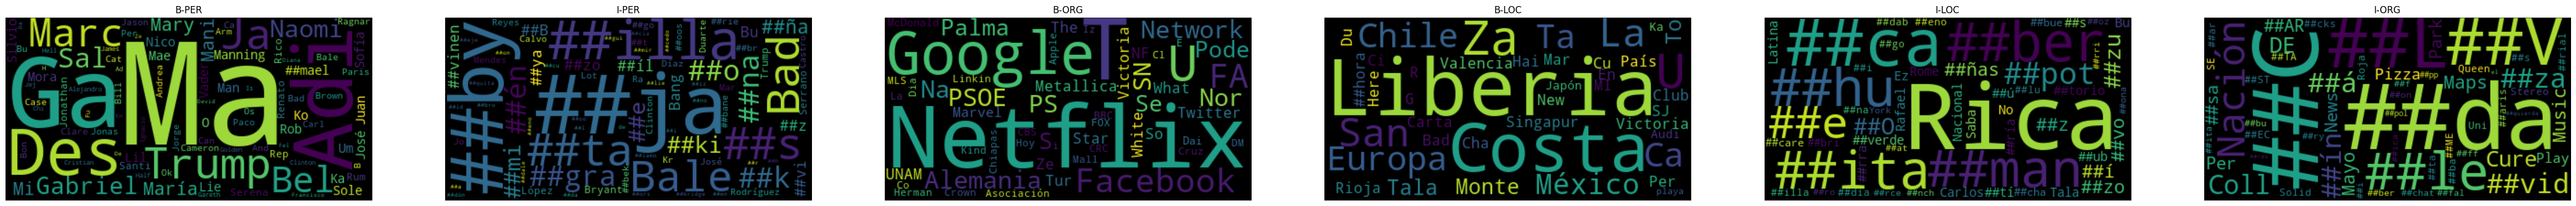

In [75]:
total_plots = len(df_result.entity.unique())
fig = plt.figure(figsize=(60, 60))

for i in range(total_plots):
    ax = fig.add_subplot(1,total_plots,i+1)
    dictio = get_dict_for_wordcloud(label_= df_result.entity.unique()[i], dfResultNer = df_result)
    wc=WordCloud(random_state=123) 
    wc.generate_from_frequencies(frequencies=dictio)  
    plt.subplot(1, total_plots, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(df_result.entity.unique()[i])


### mrm8488/TinyBERT-spanish-uncased-finetuned-ner

In [82]:
%%time
task_ = None#'ner'
model_ = 'mrm8488/TinyBERT-spanish-uncased-finetuned-ner'
df_result =getNerModel(task_, model_)
df_result.head(5)

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


CPU times: user 3.7 s, sys: 1.07 s, total: 4.77 s
Wall time: 4.65 s


text     word entity
0  Mae mañana llego a las cuidado te quedas dormi...    Liena  B-PER
1  Acá tengo pero ugh la canela no me gusta mucho...  Gracias  B-PER
2  Acá tengo pero ugh la canela no me gusta mucho...     Kris  I-PER
3  Y las emergencias La gente que necesita ir a h...      Los  B-LOC
4  Y las emergencias La gente que necesita ir a h...     Ahhh  B-LOC

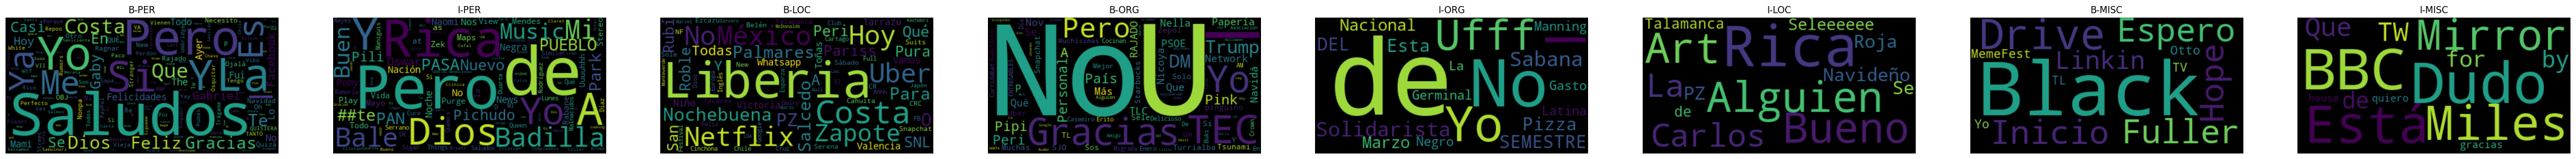

In [83]:
total_plots = len(df_result.entity.unique())
fig = plt.figure(figsize=(60, 60))

for i in range(total_plots):
    ax = fig.add_subplot(1,total_plots,i+1)
    dictio = get_dict_for_wordcloud(label_= df_result.entity.unique()[i], dfResultNer = df_result)
    wc=WordCloud(random_state=123) 
    wc.generate_from_frequencies(frequencies=dictio)  
    plt.subplot(1, total_plots, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(df_result.entity.unique()[i])


### CenIA/distillbert-base-spanish-uncased-finetuned-ner

In [78]:
%%time
task_ = None#'ner'
model_ = 'CenIA/distillbert-base-spanish-uncased-finetuned-ner'
df_result =getNerModel(task_, model_)
df_result.head(5)

Downloading:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

CPU times: user 16 s, sys: 3.15 s, total: 19.1 s
Wall time: 16.2 s


text   word   entity
0  Bueno no es tanto lo mayor como cuánto de camp...  bueno  LABEL_0
1  Bueno no es tanto lo mayor como cuánto de camp...     no  LABEL_0
2  Bueno no es tanto lo mayor como cuánto de camp...     es  LABEL_0
3  Bueno no es tanto lo mayor como cuánto de camp...  tanto  LABEL_0
4  Bueno no es tanto lo mayor como cuánto de camp...     lo  LABEL_0

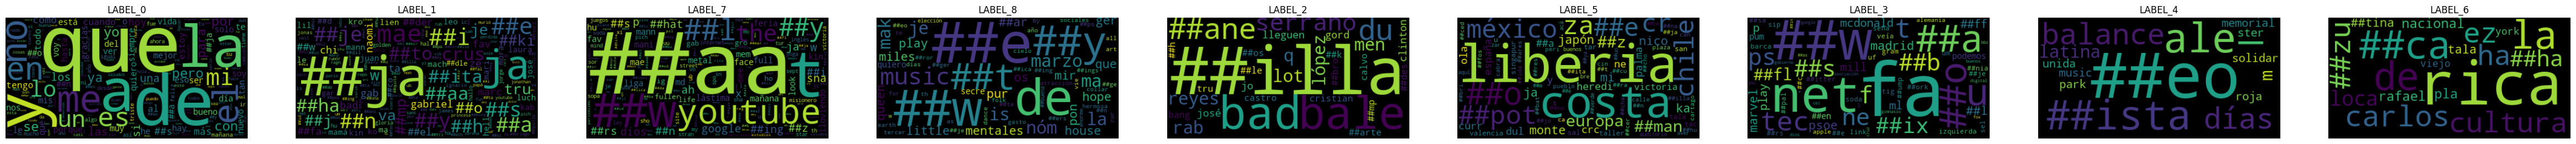

In [79]:
total_plots = len(df_result.entity.unique())
fig = plt.figure(figsize=(60, 60))

for i in range(total_plots):
    ax = fig.add_subplot(1,total_plots,i+1)
    dictio = get_dict_for_wordcloud(label_= df_result.entity.unique()[i], dfResultNer = df_result)
    wc=WordCloud(random_state=123) 
    wc.generate_from_frequencies(frequencies=dictio)  
    plt.subplot(1, total_plots, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(df_result.entity.unique()[i])


### Conclusiones

Podemos observar que la ultima metodologia empleada, tiene poca claridad en los labels asociados.  Rescatamos los siguientes comentarios_ 
    - *Label 5* tiene el wordcloud asociado a ciudades, similar al proceso B-LOC
    - *label 2* presenta la ifnroamción de textos en ingles. 
    - *label 7* extrae la ifnormación de sitios web, esto es curioso ya que no todos los elementos se incluyen debido a la limpieza previa que realizamos. 

para los otros procesos el modelo basado en BERT-tiny tiene los siguientes comentarios: 
    - presenta una mayor concentración de nombres de personas y localizaciones
    - No representa información de redes sociales, presentadas en el texto. 
    - Encuentra dos wordcloud de textos en ingles, para entender la jerga de los tweets. 
    
Para la implementación del modelo Bert Multilenguaje, concluimos: 
    - extrae de manera más clara la información de redes sociales.
    - se logra visualizar mejor la presentación de información de ciudades. 
    
    
En general y como conclusión, la selección de modelos, depende de la caracteristica que queramos incluir dentro del ejercicio. Y debe ser de minucioso cuidado la selección de un modelo NER para este proceso, pero la vinculación de varios y un exploratorio apropiado, permite generar varios insights que un solo modelo no genere. 

In [81]:
wc.words_

{'rica': 1.0,
 '##ca': 0.2857142857142857,
 'de': 0.2857142857142857,
 'la': 0.2857142857142857,
 'carlos': 0.14285714285714285,
 'cultura': 0.14285714285714285,
 '##zu': 0.14285714285714285,
 'ez': 0.14285714285714285,
 'ha': 0.14285714285714285,
 '##ha': 0.14285714285714285,
 'loca': 0.14285714285714285,
 'nacional': 0.14285714285714285,
 'pla': 0.14285714285714285,
 'rafael': 0.14285714285714285,
 '##tina': 0.14285714285714285,
 'tala': 0.14285714285714285,
 'viejo': 0.14285714285714285,
 'york': 0.14285714285714285}

# 6. Apoyado en word embeddings, realizar un gráfico t-sne para los conceptos claves del tema (explicar grupos potenciales que se observan en el gráfico).Apoyado en word embeddings, realizar un gráfico t-sne para los conceptos claves del tema (explicar grupos potenciales que se observan en el gráfico).

Para este proceso, usaremos una tockenización basada en el wordcloud generado por BERT-Tiny que observamos una  mayor relación en palabras para trabajar

Con base en ello crearemos los word embedding para generar el gráfico T-SNE

In [119]:
%%time
task_ = None#'ner'
model_ = 'mrm8488/TinyBERT-spanish-uncased-finetuned-ner'
df_result =getNerModel(task_, model_)
df_result.head(5)

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


CPU times: user 3.69 s, sys: 1.01 s, total: 4.7 s
Wall time: 4.63 s


text     word entity
0  Mae mañana llego a las cuidado te quedas dormi...    Liena  B-PER
1  Acá tengo pero ugh la canela no me gusta mucho...  Gracias  B-PER
2  Acá tengo pero ugh la canela no me gusta mucho...     Kris  I-PER
3  Y las emergencias La gente que necesita ir a h...      Los  B-LOC
4  Y las emergencias La gente que necesita ir a h...     Ahhh  B-LOC

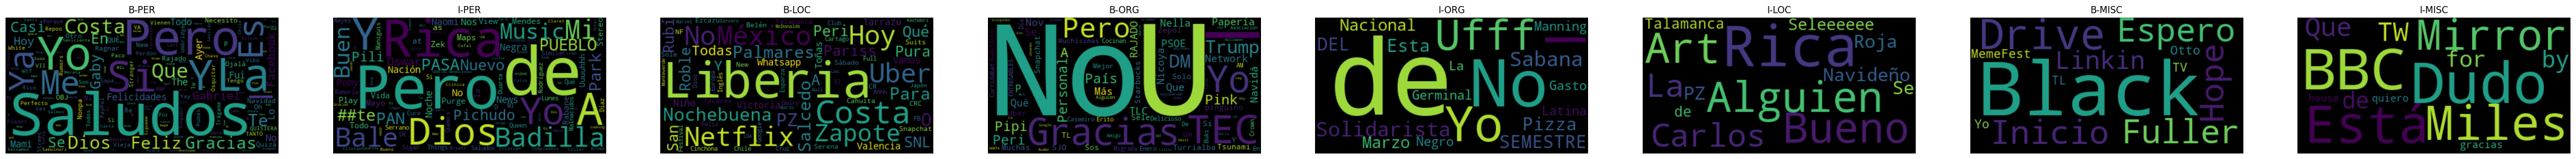

In [120]:
total_plots = len(df_result.entity.unique())
fig = plt.figure(figsize=(60, 60))

for i in range(total_plots):
    ax = fig.add_subplot(1,total_plots,i+1)
    dictio = get_dict_for_wordcloud(label_= df_result.entity.unique()[i], dfResultNer = df_result)
    wc=WordCloud(random_state=123) 
    wc.generate_from_frequencies(frequencies=dictio)  
    plt.subplot(1, total_plots, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(df_result.entity.unique()[i])


In [121]:
unionWCList = list()
for i in df_result.entity.unique():
    dictio = get_dict_for_wordcloud(label_= 'B-PER', dfResultNer = df_result)
    wc_1=WordCloud(random_state=123) 
    wc_1.generate_from_frequencies(frequencies=dictio) 
    unionWCList.append(list(wc_1.words_.keys()))


In [140]:
# creando modelo
model_tweets = Word2Vec(unionWCList, vector_size = 100, window = 5, seed= 123)

print('Imprimiendo vocabulario')
print(list(model_tweets.wv.index_to_key)[:100])
# agregar visualizaciones
model_tweets.wv.similar_by_word('Perfecto')


Imprimiendo vocabulario
['iCon', 'Renato', 'Tengo', 'TANTO', 'Sí', 'VII', 'Repoo', 'AMP', 'PayPal', 'Paco', 'Perdón', 'Trágame', 'Perfecto', 'Osquitar', 'Planet', 'Por', 'Porque', 'Pumas', 'QUISIERA', 'Ojalá', 'Todos', 'Tw', 'P', 'Street', 'Samulnori', 'My', 'Salmos', 'Saliamos', 'Rumors', 'Son', 'Sopa', 'Stranger', 'Yay', 'Umbridge', 'YA', 'Wtf', 'White', 'Vienen', 'Vieja', 'Vibo', 'Rico', 'Vas', 'Oh', 'QUÉ', 'Senicienta', 'Costa', 'Casi', 'Se', 'En', 'Te', 'Feliz', 'Gracias', 'Dios', 'Que', 'Me', 'Gabriel', 'Ya', 'Es', '_', 'Si', 'Y', 'La', 'Yo', 'Pero', 'Gaby', 'Facebook', 'OBJ', 'Ragnar', 'Navidad', 'Necesito', 'New', 'Ni', 'Rajado', 'Re', 'Nonpa', 'Quizá', 'Otro', 'Hoy', 'Todo', 'Lo', 'The', 'No', 'Mami', 'Ayer', 'Fui', 'Felicidades', 'Santi', 'Sentido', 'Hijos', 'José', 'Mae', 'Abre', 'ME', 'Esta', 'Llorar', 'L', 'Kindle', 'Kabek', 'Jonathan', 'Marce']


[('Duré', 0.27690112590789795),
 ('Gaby', 0.23896263539791107),
 ('Yo', 0.21697816252708435),
 ('Dia', 0.2153850495815277),
 ('Hellen', 0.21420566737651825),
 ('White', 0.1876620054244995),
 ('Gareth', 0.17862100899219513),
 ('Repoo', 0.1772509664297104),
 ('Santi', 0.17128218710422516),
 ('Wtf', 0.16987848281860352)]

Vemos que los grupos son pequeños, para multiples palabras del vocabulario, consideraremos, todo el que se genero, para ver el resultado

Modelo T-SNE

In [186]:
tsne=manifold.TSNE(perplexity=2, random_state=1234567898)
sample_vocabulary = list(model_tweets.wv.index_to_key)[:50]
print(len(sample_vocabulary))

vectors = model_tweets.wv[sample_vocabulary]
reduccion=tsne.fit_transform(vectors)

50


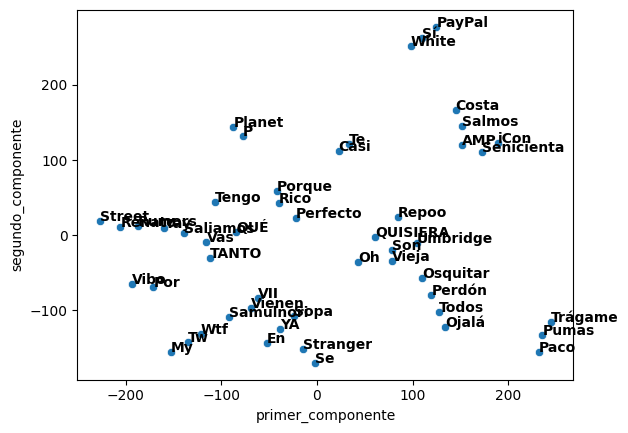

In [187]:
# graficando el plano
base=pd.DataFrame()
base["primer_componente"]=reduccion[:,0]
base["segundo_componente"]=reduccion[:,1]
base["nombres"]=sample_vocabulary


graf1=sns.scatterplot(x="primer_componente", y="segundo_componente", data=base)

for line in range(0,base.shape[0]):
     graf1.text(base.primer_componente[line]+0.01, base.segundo_componente[line], 
     base.nombres[line], horizontalalignment='left', 
     size='medium', color='black', weight='semibold')

**Conclusiones**

Al usar los wordcloud como vocabulario para la tokenización encontramos grupos interesantes, aunque consideramos una muestra, podemos ver relaciones como:
- trágame Pumas Paco
- Costa Salmos Snicienta
- Pypal White
- porque RICO PERFECTO

o abreviaciones como 
- MY TW WTF

así como algunos complementos entre palabras
- planet p
- stranger se


Lo que nos lleva a concluir que el usar wordcloud permite definir una buena aproximación entre palabras, acorde a lo que observamos. Pero entre más refinado el modelo en el cual construimos el wordcloud, mejor será el proceso. 